In [33]:
import time
from glob import glob
from tqdm import tqdm
import pandas as pd
from utils import get_hour_crawl_df_lst, get_daily_origin_df_dict
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from concurrent.futures import ProcessPoolExecutor
import pickle
from itertools import combinations
sns.set_palette("Set1", 7)
sns.color_palette("Set1", 7)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)]

In [34]:
def get_date(csv_path):
    return csv_path.split('/')[-1][:6]

In [35]:
sda_path = '/mnt/sda/tnecniv/tnecniv-2023/'
weeks_folder= sorted(glob(sda_path+'*-*/'))
origins_folder = sorted(glob(sda_path+'daily_origin/*.csv'))

In [36]:
first_week_idx = 44
last_week_idx = 46
selected_weeks = weeks_folder[first_week_idx:last_week_idx]
selected_weeks_hour_csv = [csv for week in selected_weeks for csv in sorted(glob(week+'*-*.csv'))]
day_csv_lst = [selected_weeks_hour_csv[24*i:24*(i+1)] for i in range(len(selected_weeks_hour_csv) // 24)]
date_range = [get_date(csv) for csv in [selected_weeks_hour_csv[24*i] for i in range(7*(last_week_idx-first_week_idx))]]
first_day = date_range[0]
last_day = date_range[-1]
day_zero = [get_date(sorted(glob(weeks_folder[first_week_idx-1]+'*-*.csv'))[-1])]
selected_weeks_origins = [origin for origin in origins_folder if get_date(origin) in day_zero + date_range]
origins_df_dict = get_daily_origin_df_dict(selected_weeks_origins)
first_day, last_day

100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


('240519', '240601')

In [76]:
languages = ['en', 'es', 'pt', 'ru', 'de', 'fr', 'ja', 'zh', 'pl', 'it', 'tr', 'th', 'ar', 'cs', 'ko', 'hu', 'uk', 'fi', 'other', 'sv', 'el', 'nl', 'da', 'no', 'zh-hk', 'tl', 'bg', 'ro', 'sk', 'id', 'hi', 'ca', 'asl', 'vi', 'ms']
origins = ['usw23', 'sin03', 'pdx05', 'iad06', 'cmh01', 'ams04', '']
origin_nine = ['iad06', 'ams04', 'sin03', 'cmh01', 'pdx05', 'muc03', '', 'usw22', 'usw23']
origin_continent = {
    'as': ['sin03'],
    'eu': ['ams04', 'muc03'],
    'na': ['iad06', 'cmh01', 'pdx05', 'usw22', 'usw23'],
}
full_language_names = {
    'en': 'English', 'es': 'Spanish', 'pt': 'Portuguese', 'ru': 'Russian', 'de': 'German', 'fr': 'French', 'ja': 'Japanese', 'zh': 'Chinese', 'pl': 'Polish', 'it': 'Italian', 'tr': 'Turkish', 'th': 'Thai', 'ar': 'Arabic', 'cs': 'Czech', 'ko': 'Korean'
}
full_vc_sc = {'vc': '# of Viewers', 'sc': '# of Streamers'}
weekday_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
linestyle_dict = {0: 'solid', 1: 'dotted', 2: 'dashed', 3: 'dashdot'}
ccl_lst = ['DrugsIntoxication', 'Gambling', 'MatureGame', 'ProfanityVulgarity', 'SexualThemes', 'ViolentGraphic']
ccl_translate ={
    'MatureGame': 'Mature-Rated Games',
    'SexualThemes': 'Sexual Themes',
    'DrugsIntoxication': 'Drugs, Intoxication, or Excessive Tobacco Use',
    'ViolentGraphic': 'Violent and Graphic Depictions',
    'ProfanityVulgarity': 'Significant Profanity or Vulgarity',
    'Gambling': 'Gambling'
}
ccl_dict = {c[0]:c for c in ccl_lst}
ccl_pair_translate = {
    ('D', 'G'): 'Drugs, Intoxication, or Excessive Tobacco Use | Gambling',
    ('D', 'M'): 'Mature-Rated Games | Drugs, Intoxication, or Excessive Tobacco Use',
    ('D', 'P'): 'Significant Profanity or Vulgarity | Drugs, Intoxication, or Excessive Tobacco Use',
    ('D', 'S'): 'Drugs, Intoxication, or Excessive Tobacco Use | Sexual Themes',
    ('D', 'V'): 'Drugs, Intoxication, or Excessive Tobacco Use | Violent and Graphic Depictions',
    ('G', 'M'): 'Mature-Rated Games | Gambling',
    ('G', 'P'): 'Significant Profanity or Vulgarity | Gambling',
    ('G', 'S'): 'Gambling | Sexual Themes',
    ('G', 'V'): 'Gambling | Violent and Graphic Depictions',
    ('M', 'P'): 'Mature-Rated Games | Significant Profanity or Vulgarity',
    ('M', 'S'): 'Mature-Rated Games | Sexual Themes',
    ('M', 'V'): 'Mature-Rated Games | Violent and Graphic Depictions',
    ('P', 'S'): 'Significant Profanity or Vulgarity | Sexual Themes',
    ('P', 'V'): 'Significant Profanity or Vulgarity | Violent and Graphic Depictions',
    ('S', 'V'): 'Sexual Themes | Violent and Graphic Depictions',}

CCL by region

In [38]:
csv = day_csv_lst[0][0]
df = get_hour_crawl_df_lst(csv, origins_df_dict[get_date(csv)])[0]
small_df = df[['language', 'content_classification_labels', 'viewer_count']]
small_df[small_df['content_classification_labels'] == '']

,language,content_classification_labels,viewer_count
0,ru,,36009
1,en,,35172
3,en,,23325
5,ja,,16170
6,pt,,15870
...,...,...,...
103348,zh,,0
103349,en,,0
103350,en,,0
103351,en,,0


In [39]:
{c_pair:[] for c_pair in combinations(ccl_dict.keys(), 2)}

{('D', 'G'): [],
 ('D', 'M'): [],
 ('D', 'P'): [],
 ('D', 'S'): [],
 ('D', 'V'): [],
 ('G', 'M'): [],
 ('G', 'P'): [],
 ('G', 'S'): [],
 ('G', 'V'): [],
 ('M', 'P'): [],
 ('M', 'S'): [],
 ('M', 'V'): [],
 ('P', 'S'): [],
 ('P', 'V'): [],
 ('S', 'V'): []}

In [40]:
def get_ccl_stream_count(day):
    res1 = {'sc': {c_abbr: [] for c_abbr in ccl_dict.keys()}, 'vc': {c_abbr: [] for c_abbr in ccl_dict.keys()}}
    res2 = {'sc': {c_pair: [] for c_pair in combinations(ccl_dict.keys(), 2)}, 'vc': {c_pair: [] for c_pair in combinations(ccl_dict.keys(), 2)}}
    res3 = {'none': [], 'total_sc': [], 'total_vc': []}
    for hour in day:
        df_lst = get_hour_crawl_df_lst(hour)
        for df in df_lst:
            small_df = df[['language', 'content_classification_labels', 'viewer_count']]
            res3['total_sc'].append(small_df.shape[0])
            res3['total_vc'].append(small_df['viewer_count'].sum())
            res3['none'].append(small_df[small_df['content_classification_labels'] == ''].shape[0])
            for c_abbr in ccl_dict.keys():
                filter_single = small_df[small_df['content_classification_labels'].str.contains(c_abbr)]
                res1['sc'][c_abbr].append(filter_single.shape[0])
                res1['vc'][c_abbr].append(filter_single['viewer_count'].sum())
            for c1, c2 in res2['sc'].keys():
                filter_double = small_df[small_df['content_classification_labels'].str.contains(c1) & small_df['content_classification_labels'].str.contains(c2)]
                res2['sc'][(c1, c2)].append(filter_double.shape[0])
                res2['vc'][(c1, c2)].append(filter_double['viewer_count'].sum())
    return res1, res2, res3

In [41]:
# ccl_stream_count_single = {'sc': {c_abbr: [] for c_abbr in ccl_dict.keys()}, 'vc': {c_abbr: [] for c_abbr in ccl_dict.keys()}}
# no_ccls = {'none': [], 'total_sc': [], 'total_vc': []}
# ccl_stream_count_double = {'sc': {c_pair: [] for c_pair in combinations(ccl_dict.keys(), 2)}, 'vc': {c_pair: [] for c_pair in combinations(ccl_dict.keys(), 2)}}

# with ProcessPoolExecutor(max_workers=7) as executor:
#     for res1, res2, res3 in list(tqdm(executor.map(get_ccl_stream_count, day_csv_lst), total=len(day_csv_lst))):
#         for ccl_abbr in res1['sc'].keys():
#             ccl_stream_count_single['sc'][ccl_abbr].extend(res1['sc'][ccl_abbr])
#             ccl_stream_count_single['vc'][ccl_abbr].extend(res1['vc'][ccl_abbr])
#         for c1, c2 in res2['sc'].keys():
#             ccl_stream_count_double['sc'][(c1, c2)].extend(res2['sc'][(c1, c2)])
#             ccl_stream_count_double['vc'][(c1, c2)].extend(res2['vc'][(c1, c2)])
        
#         no_ccls['none'].extend(res3['none'])
#         no_ccls['total_sc'].extend(res3['total_sc'])
#         no_ccls['total_vc'].extend(res3['total_vc'])

# with open('./result_collection/ccl_2405/ccl_stream_count_single.pkl', 'wb') as f1, open('./result_collection/ccl_2405/ccl_stream_count_double.pkl', 'wb') as f2, open('./result_collection/ccl_2405/no_ccls.pkl', 'wb') as f3:
#     pickle.dump(ccl_stream_count_single, f1, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(ccl_stream_count_double, f2, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(no_ccls, f3, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 14/14 [03:53<00:00, 16.66s/it]


In [117]:
with open('./result_collection/ccl_2405/ccl_stream_count_single.pkl', 'rb') as f1, open('./result_collection/ccl_2405/ccl_stream_count_double.pkl', 'rb') as f2, open('./result_collection/ccl_2405/no_ccls.pkl', 'rb') as f3:
    ccl_stream_count_single = pickle.load(f1)
    ccl_stream_count_double = pickle.load(f2)
    no_ccls = pickle.load(f3)

In [52]:
df = pd.DataFrame(no_ccls).T
df.insert(0, 'avg', df.mean(axis=1))
df = df['avg'].astype(int).to_frame()
df

,avg
none,57977
total_sc,92182
total_vc,2315993


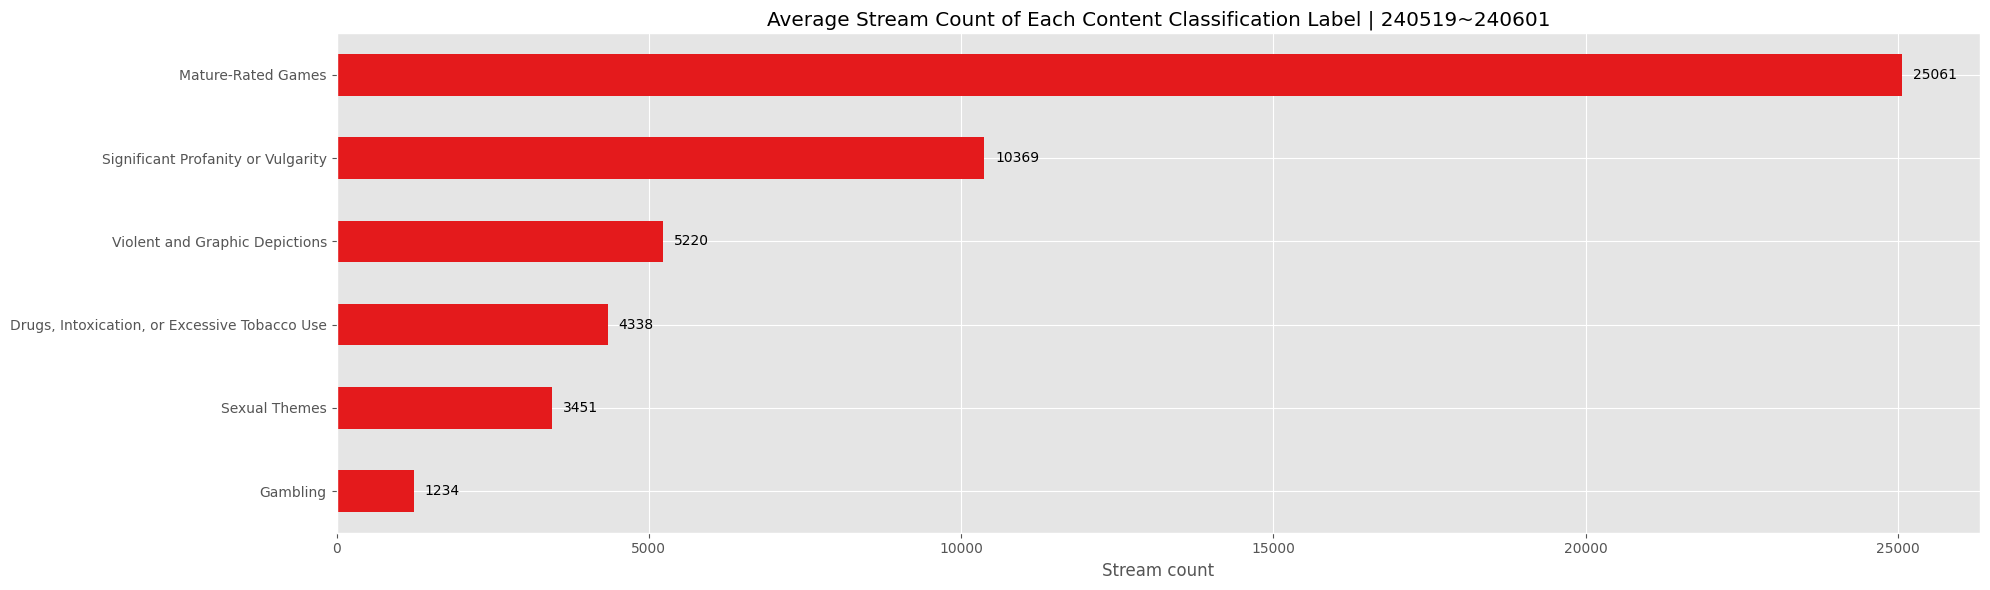

In [122]:
fig, ax = plt.subplots(1, figsize=(20, 6))
ccl_sc_df = pd.DataFrame(ccl_stream_count_single['sc']).T
ccl_sc_df.insert(0, 'avg', ccl_sc_df.mean(axis=1))
ccl_sc_df = ccl_sc_df['avg'].astype(int).rename(ccl_dict).rename({'total': 'Total'}).sort_values().rename(ccl_translate)
ax = ccl_sc_df.plot(kind='barh')
ax.set_title(f'Average Stream Count of Each Content Classification Label | {first_day}~{last_day}')
ax.set_xlabel('Stream count')

ax.bar_label(ax.containers[0], padding=8)
fig.tight_layout()

In [ ]:
ccl_sc_df = ccl_sc_df['avg'].astype(int).rename(ccl_dict).rename({'total': 'Total'}).sort_values().rename(ccl_translate)
ax = ccl_sc_df.plot(kind='barh')
ax.set_title(f'Average Stream Count of Each Content Classification Label | {first_day}~{last_day}')
ax.set_xlabel('Stream count')

ax.bar_label(ax.containers[0], padding=8)
fig.tight_layout()

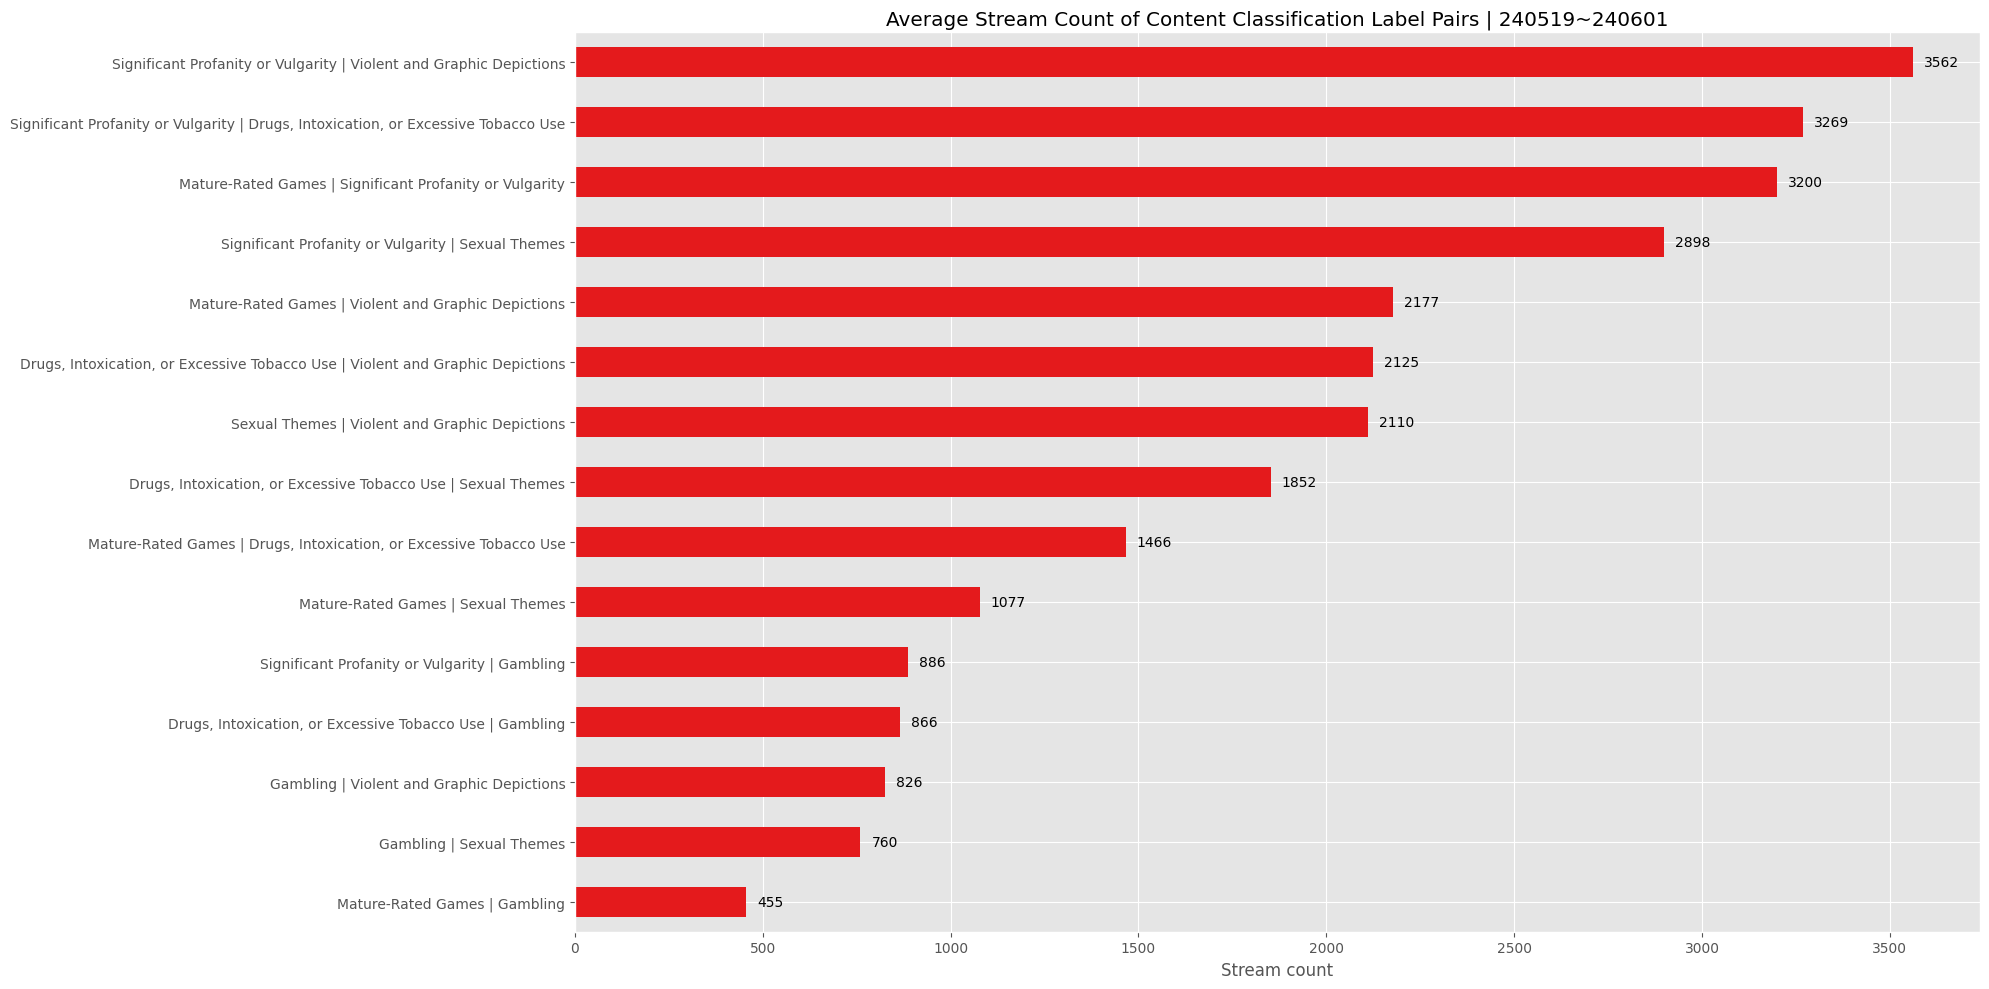

In [78]:
fig, ax = plt.subplots(1, figsize=(20, 10))
df2 = pd.DataFrame(ccl_stream_count_double['sc']).T
df2.insert(0, 'avg', df2.mean(axis=1))
df2 = df2['avg'].astype(int)
df2 = df2.sort_values()
df2.index = df2.index.to_flat_index()
df2 = df2.rename(ccl_pair_translate)
ax = df2.plot(kind='barh')
ax.set_title(f'Average Stream Count of Content Classification Label Pairs | {first_day}~{last_day}')
ax.set_xlabel('Stream count')
ax.bar_label(ax.containers[0], padding=8)
fig.tight_layout()

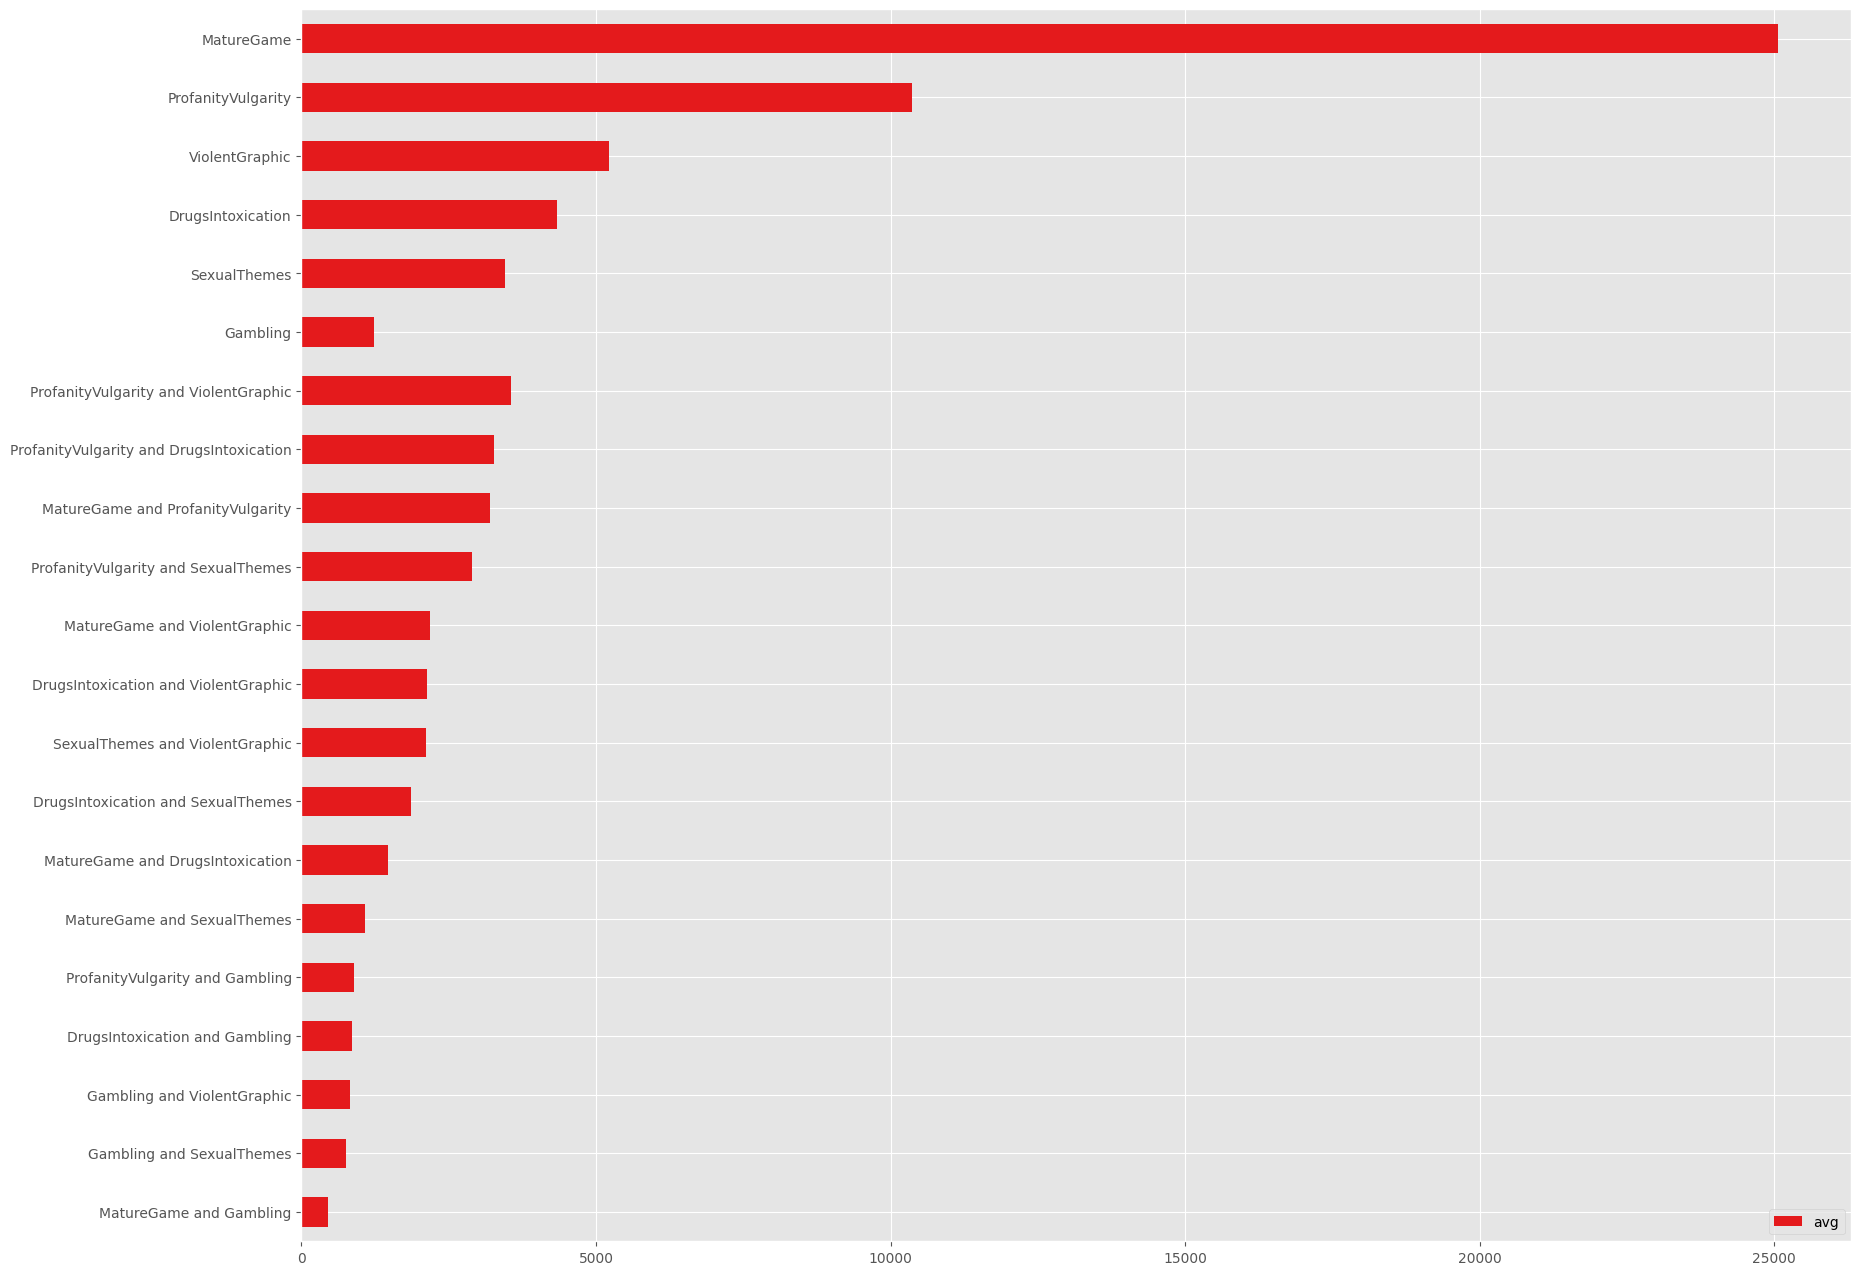

In [46]:
fig, ax = plt.subplots(1, figsize=(20, 16))
ax = pd.concat([df2, df]).to_frame().plot(kind='barh', ax=ax)

CCL by region

In [166]:
selected_lang = ['en', 'es', 'pt', 'ru', 'de', 'fr', 'ja', 'zh']

In [162]:
csv = day_csv_lst[0][0]

df = get_hour_crawl_df_lst(csv, origins_df_dict[get_date(csv)])[0]
small_df = df[['language', 'content_classification_labels']]
small_df[(small_df['language'] == 'en') & (small_df['content_classification_labels'].str.contains('M'))]

,language,content_classification_labels
4,en,M
19,en,M
21,en,M
22,en,M
36,en,M
...,...,...
103323,en,M
103325,en,M
103333,en,M
103335,en,M


In [98]:
def get_language_ccl_stream_count(day):
    res = {l:{c: [] for c in ccl_dict.keys()} for l in selected_lang}
    for hour in day:
        df_lst = get_hour_crawl_df_lst(hour)
        for df in df_lst:
            small_df = df[['content_classification_labels', 'language']]
            for l in selected_lang:
                for c in ccl_dict.keys():
                    res[l][c].append(small_df[(small_df['content_classification_labels'].str.contains(c)) & (small_df['language'] == l)].shape[0])
    return res

In [99]:
ccl_lang_sc = {l:{c: [] for c in ccl_dict.keys()} for l in selected_lang}
with ProcessPoolExecutor(max_workers=7) as executor:
     for res in list(tqdm(executor.map(get_language_ccl_stream_count, day_csv_lst), total=len(day_csv_lst))):
        for l in selected_lang:
            for c in ccl_dict.keys():
                ccl_lang_sc[l][c].extend(res[l][c])


100%|██████████| 14/14 [05:31<00:00, 23.69s/it]


In [159]:
merged_df

,English,Spanish,Portuguese,Russian,German,French,Japanese,Chinese,Others
"Drugs, Intoxication, or Excessive Tobacco Use",3156,278,152,115,261,138,22,27,189
Gambling,755,113,95,18,60,40,13,25,115
Mature-Rated Games,15010,2075,1567,1406,1256,1170,642,221,1714
Significant Profanity or Vulgarity,6780,730,598,656,521,351,38,128,567
Sexual Themes,2209,285,125,166,236,110,48,89,183
Violent and Graphic Depictions,3487,398,228,153,323,197,87,94,253


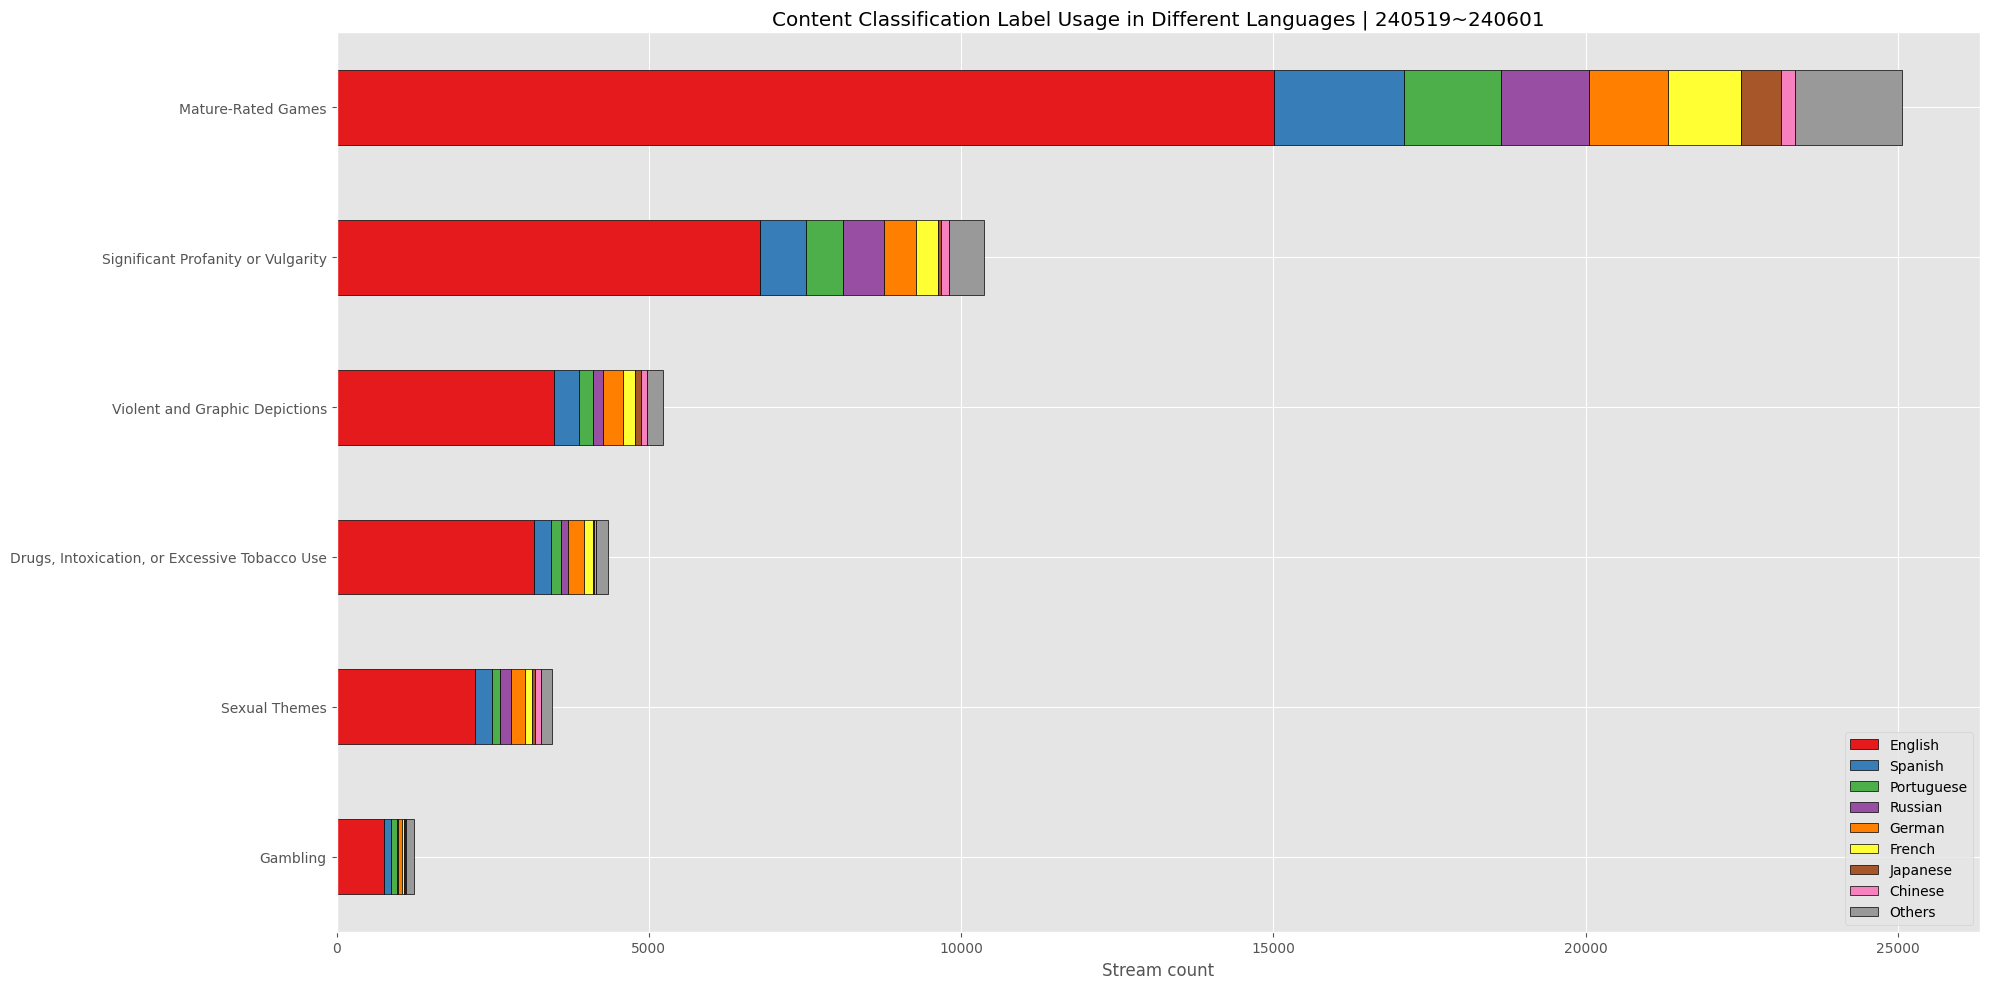

In [183]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ccl_lang_df = pd.DataFrame()
for l in selected_lang:
    df = pd.DataFrame(ccl_lang_sc[l]).T
    ccl_lang_df.insert(0, l, df.mean(axis=1).astype(int))
ccl_lang_df = ccl_lang_df.rename(index=ccl_dict, columns=full_language_names).rename(ccl_translate)
merged_df = ccl_lang_df.join(ccl_sc_df)
merged_df.insert(0, 'Others', merged_df['avg'] - merged_df.iloc[:, :-1].sum(axis=1))
merged_df = merged_df.sort_values('avg').drop('avg', axis=1).iloc[:, ::-1]
ax = merged_df.plot(kind='barh', stacked=True, ax=ax, colormap="Set1", edgecolor='black', linewidth=.5)
ax.set_xlabel('Stream count')
ax.set_title(f'Content Classification Label Usage in Different Languages | {first_day}~{last_day}')
fig.tight_layout()

In [123]:
ccl_sc_df

Gambling                                          1234
Sexual Themes                                     3451
Drugs, Intoxication, or Excessive Tobacco Use     4338
Violent and Graphic Depictions                    5220
Significant Profanity or Vulgarity               10369
Mature-Rated Games                               25061
Name: avg, dtype: int64